#   Исследования причин убытков приложения Procrastinate Pro+

Задача — разобраться в причинах убытков последних нескольких месяцев и дать рекомендации для решения проблем чтобы компания вышла в плюс. Нужна изучить данные о пользователях, привлечённых с 1 мая по 27 октября 2019 года. 
- Первый этап — изучение общий информации и предобработка данных.
- Второй этап — создание функций для расчёта и анализа LTV, ROI, удержания и конверсии.
- Третий  этап — исследовательский анализ данных, изучение откуда приходят пользователи и какими устройствами они пользуются.
- Четвертый этап — выяснить сколько стоит привлечение пользователей из различных рекламных каналов, сколько денег приносит каждый клиент. 
- Пятый этап — оцените окупаемость рекламы, когда расходы на привлечение клиента окупаются, какие факторы мешают привлечению клиентов.
- Шестой этап — общий вывод.

Среди данных у нас есть  лог сервера с данными об их посещениях, выгрузка их покупок за этот период, рекламные расходы.

##   Изучение общий информации и предобработка данных.

Загружаем данные о визитах, заказах и рекламных расходах из CSV-файлов в переменные.
Изучим данные и выполним предобработку. Проверим данные на пропуски и дубликаты. 

In [1]:
import pandas as pd
import numpy as np

In [2]:
from datetime import datetime, timedelta
from matplotlib import pyplot as plt

In [3]:
try:
    visits = pd.read_csv('/datasets/visits_info_short.csv')
except:
    visits = pd.read_csv('C:\\Users\\User\\Downloads\\visits_info_short.csv')    

In [4]:
visits.columns = visits.columns.str.lower()
visits = visits.rename(
    columns={'user id' : 'user_id', 'session start' : 'session_start', 'session end' : 'session_end'}
)
visits['session_start'] = pd.to_datetime(visits['session_start'])
visits['session_end'] = pd.to_datetime(visits['session_end'])
visits.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 309901 entries, 0 to 309900
Data columns (total 6 columns):
 #   Column         Non-Null Count   Dtype         
---  ------         --------------   -----         
 0   user_id        309901 non-null  int64         
 1   region         309901 non-null  object        
 2   device         309901 non-null  object        
 3   channel        309901 non-null  object        
 4   session_start  309901 non-null  datetime64[ns]
 5   session_end    309901 non-null  datetime64[ns]
dtypes: datetime64[ns](2), int64(1), object(3)
memory usage: 14.2+ MB


In [5]:
try:
    orders = pd.read_csv('/datasets/orders_info_short.csv')
except:
    orders = pd.read_csv('C:\\Users\\User\\Downloads\\orders_info_short.csv')

In [6]:
orders.columns = orders.columns.str.lower()
orders = orders.rename(columns={'user id' : 'user_id', 'event dt' : 'event_dt'})
orders['event_dt'] = pd.to_datetime(orders['event_dt'])
orders.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 40212 entries, 0 to 40211
Data columns (total 3 columns):
 #   Column    Non-Null Count  Dtype         
---  ------    --------------  -----         
 0   user_id   40212 non-null  int64         
 1   event_dt  40212 non-null  datetime64[ns]
 2   revenue   40212 non-null  float64       
dtypes: datetime64[ns](1), float64(1), int64(1)
memory usage: 942.6 KB


In [7]:
try:
    costs = pd.read_csv('/datasets/costs_info_short.csv')   
except:
    costs = pd.read_csv('C:\\Users\\User\\Downloads\\costs_info_short.csv')

In [8]:
costs.columns = costs.columns.str.lower()
costs['dt'] = pd.to_datetime(costs['dt']).dt.date 
costs.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1800 entries, 0 to 1799
Data columns (total 3 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   dt       1800 non-null   object 
 1   channel  1800 non-null   object 
 2   costs    1800 non-null   float64
dtypes: float64(1), object(2)
memory usage: 42.3+ KB


In [9]:
#visits.head(), orders.head(), costs.head()
visits[visits.duplicated()]
visits.duplicated().sum()

0

In [10]:
orders[orders.duplicated()]
orders.duplicated().sum()

0

In [11]:
costs[costs.duplicated()]
orders.duplicated().sum()

0

Пропуски и дубликаты отсутствуют. Внесены изменения в названия столбцов для более удобного использования. Тип данных столбцов с датами изменен на подходящий тип для упрощения анализа. 

## Создание функции для расчёта и анализа LTV, ROI, удержания и конверсии.

Это функции для вычисления значений метрик:

- `get_profiles()` — для создания профилей пользователей,
- `get_retention()` — для подсчёта Retention Rate,
- `get_conversion()` — для подсчёта конверсии,
- `get_ltv()` — для подсчёта LTV.

А также функции для построения графиков:

- `filter_data()` — для сглаживания данных,
- `plot_retention()` — для построения графика Retention Rate,
- `plot_conversion()` — для построения графика конверсии,
- `plot_ltv_roi` — для визуализации LTV и ROI.

In [12]:
# функция для создания пользовательских профилей

def get_profiles(sessions, orders, ad_costs, event_names=[]):

    # находим параметры первых посещений
    profiles = (
        sessions.sort_values(by=['user_id', 'session_start'])
        .groupby('user_id')
        .agg(
            {
                'session_start': 'first',
                'channel': 'first',
                'device': 'first',
                'region': 'first',
            }
        )
        .rename(columns={'session_start': 'first_ts'})
        .reset_index()
    )

    # для когортного анализа определяем дату первого посещения
    # и первый день месяца, в который это посещение произошло
    profiles['dt'] = profiles['first_ts'].dt.date
    profiles['month'] = profiles['first_ts'].astype('datetime64[M]')

    # добавляем признак платящих пользователей
    profiles['payer'] = profiles['user_id'].isin(orders['user_id'].unique())

    # добавляем флаги для всех событий из event_names
    for event in event_names:
        if event in events['event_name'].unique():
            profiles[event] = profiles['user_id'].isin(
                events.query('event_name == @event')['user_id'].unique()
            )

    # считаем количество уникальных пользователей
    # с одинаковыми источником и датой привлечения
    new_users = (
        profiles.groupby(['dt', 'channel'])
        .agg({'user_id': 'nunique'})
        .rename(columns={'user_id': 'unique_users'})
        .reset_index()
    )

    # объединяем траты на рекламу и число привлечённых пользователей
    ad_costs = ad_costs.merge(new_users, on=['dt', 'channel'], how='left')

    # делим рекламные расходы на число привлечённых пользователей
    ad_costs['acquisition_cost'] = ad_costs['costs'] / ad_costs['unique_users']

    # добавляем стоимость привлечения в профили
    profiles = profiles.merge(
        ad_costs[['dt', 'channel', 'acquisition_cost']],
        on=['dt', 'channel'],
        how='left',
    )

    # стоимость привлечения органических пользователей равна нулю
    profiles['acquisition_cost'] = profiles['acquisition_cost'].fillna(0)

    return profiles
 

In [13]:
# функция для расчёта удержания

def get_retention(
    profiles,
    sessions,
    observation_date,
    horizon_days,
    dimensions=[],
    ignore_horizon=False,
):

    # добавляем столбец payer в передаваемый dimensions список
    dimensions = ['payer'] + dimensions

    # исключаем пользователей, не «доживших» до горизонта анализа
    last_suitable_acquisition_date = observation_date
    if not ignore_horizon:
        last_suitable_acquisition_date = observation_date - timedelta(
            days=horizon_days - 1
        )
    result_raw = profiles.query('dt <= @last_suitable_acquisition_date')

    # собираем «сырые» данные для расчёта удержания
    result_raw = result_raw.merge(
        sessions[['user_id', 'session_start']], on='user_id', how='left'
    )
    result_raw['lifetime'] = (
        result_raw['session_start'] - result_raw['first_ts']
    ).dt.days

    # функция для группировки таблицы по желаемым признакам
    def group_by_dimensions(df, dims, horizon_days):
        result = df.pivot_table(
            index=dims, columns='lifetime', values='user_id', aggfunc='nunique'
        )
        cohort_sizes = (
            df.groupby(dims)
            .agg({'user_id': 'nunique'})
            .rename(columns={'user_id': 'cohort_size'})
        )
        result = cohort_sizes.merge(result, on=dims, how='left').fillna(0)
        result = result.div(result['cohort_size'], axis=0)
        result = result[['cohort_size'] + list(range(horizon_days))]
        result['cohort_size'] = cohort_sizes
        return result

    # получаем таблицу удержания
    result_grouped = group_by_dimensions(result_raw, dimensions, horizon_days)

    # получаем таблицу динамики удержания
    result_in_time = group_by_dimensions(
        result_raw, dimensions + ['dt'], horizon_days
    )

    # возвращаем обе таблицы и сырые данные
    return result_raw, result_grouped, result_in_time 

In [14]:
# функция для расчёта конверсии

def get_conversion(
    profiles,
    purchases,
    observation_date,
    horizon_days,
    dimensions=[],
    ignore_horizon=False,
):

    # исключаем пользователей, не «доживших» до горизонта анализа
    last_suitable_acquisition_date = observation_date
    if not ignore_horizon:
        last_suitable_acquisition_date = observation_date - timedelta(
            days=horizon_days - 1
        )
    result_raw = profiles.query('dt <= @last_suitable_acquisition_date')

    # определяем дату и время первой покупки для каждого пользователя
    first_purchases = (
        purchases.sort_values(by=['user_id', 'event_dt'])
        .groupby('user_id')
        .agg({'event_dt': 'first'})
        .reset_index()
    )

    # добавляем данные о покупках в профили
    result_raw = result_raw.merge(
        first_purchases[['user_id', 'event_dt']], on='user_id', how='left'
    )

    # рассчитываем лайфтайм для каждой покупки
    result_raw['lifetime'] = (
        result_raw['event_dt'] - result_raw['first_ts']
    ).dt.days

    # группируем по cohort, если в dimensions ничего нет
    if len(dimensions) == 0:
        result_raw['cohort'] = 'All users' 
        dimensions = dimensions + ['cohort']

    # функция для группировки таблицы по желаемым признакам
    def group_by_dimensions(df, dims, horizon_days):
        result = df.pivot_table(
            index=dims, columns='lifetime', values='user_id', aggfunc='nunique'
        )
        result = result.fillna(0).cumsum(axis = 1)
        cohort_sizes = (
            df.groupby(dims)
            .agg({'user_id': 'nunique'})
            .rename(columns={'user_id': 'cohort_size'})
        )
        result = cohort_sizes.merge(result, on=dims, how='left').fillna(0)
        # делим каждую «ячейку» в строке на размер когорты
        # и получаем conversion rate
        result = result.div(result['cohort_size'], axis=0)
        result = result[['cohort_size'] + list(range(horizon_days))]
        result['cohort_size'] = cohort_sizes
        return result

    # получаем таблицу конверсии
    result_grouped = group_by_dimensions(result_raw, dimensions, horizon_days)

    # для таблицы динамики конверсии убираем 'cohort' из dimensions
    if 'cohort' in dimensions: 
        dimensions = []

    # получаем таблицу динамики конверсии
    result_in_time = group_by_dimensions(
        result_raw, dimensions + ['dt'], horizon_days
    )

    # возвращаем обе таблицы и сырые данные
    return result_raw, result_grouped, result_in_time 


In [15]:
# функция для расчёта LTV и ROI

def get_ltv(
    profiles,
    purchases,
    observation_date,
    horizon_days,
    dimensions=[],
    ignore_horizon=False,
):

    # исключаем пользователей, не «доживших» до горизонта анализа
    last_suitable_acquisition_date = observation_date
    if not ignore_horizon:
        last_suitable_acquisition_date = observation_date - timedelta(
            days=horizon_days - 1
        )
    result_raw = profiles.query('dt <= @last_suitable_acquisition_date')
    # добавляем данные о покупках в профили
    result_raw = result_raw.merge(
        purchases[['user_id', 'event_dt', 'revenue']], on='user_id', how='left'
    )
    # рассчитываем лайфтайм пользователя для каждой покупки
    result_raw['lifetime'] = (
        result_raw['event_dt'] - result_raw['first_ts']
    ).dt.days
    # группируем по cohort, если в dimensions ничего нет
    if len(dimensions) == 0:
        result_raw['cohort'] = 'All users'
        dimensions = dimensions + ['cohort']

    # функция группировки по желаемым признакам
    def group_by_dimensions(df, dims, horizon_days):
        # строим «треугольную» таблицу выручки
        result = df.pivot_table(
            index=dims, columns='lifetime', values='revenue', aggfunc='sum'
        )
        # находим сумму выручки с накоплением
        result = result.fillna(0).cumsum(axis=1)
        # вычисляем размеры когорт
        cohort_sizes = (
            df.groupby(dims)
            .agg({'user_id': 'nunique'})
            .rename(columns={'user_id': 'cohort_size'})
        )
        # объединяем размеры когорт и таблицу выручки
        result = cohort_sizes.merge(result, on=dims, how='left').fillna(0)
        # считаем LTV: делим каждую «ячейку» в строке на размер когорты
        result = result.div(result['cohort_size'], axis=0)
        # исключаем все лайфтаймы, превышающие горизонт анализа
        result = result[['cohort_size'] + list(range(horizon_days))]
        # восстанавливаем размеры когорт
        result['cohort_size'] = cohort_sizes

        # собираем датафрейм с данными пользователей и значениями CAC, 
        # добавляя параметры из dimensions
        cac = df[['user_id', 'acquisition_cost'] + dims].drop_duplicates()

        # считаем средний CAC по параметрам из dimensions
        cac = (
            cac.groupby(dims)
            .agg({'acquisition_cost': 'mean'})
            .rename(columns={'acquisition_cost': 'cac'})
        )

        # считаем ROI: делим LTV на CAC
        roi = result.div(cac['cac'], axis=0)

        # удаляем строки с бесконечным ROI
        roi = roi[~roi['cohort_size'].isin([np.inf])]

        # восстанавливаем размеры когорт в таблице ROI
        roi['cohort_size'] = cohort_sizes

        # добавляем CAC в таблицу ROI
        roi['cac'] = cac['cac']

        # в финальной таблице оставляем размеры когорт, CAC
        # и ROI в лайфтаймы, не превышающие горизонт анализа
        roi = roi[['cohort_size', 'cac'] + list(range(horizon_days))]

        # возвращаем таблицы LTV и ROI
        return result, roi

    # получаем таблицы LTV и ROI
    result_grouped, roi_grouped = group_by_dimensions(
        result_raw, dimensions, horizon_days
    )

    # для таблиц динамики убираем 'cohort' из dimensions
    if 'cohort' in dimensions:
        dimensions = []

    # получаем таблицы динамики LTV и ROI
    result_in_time, roi_in_time = group_by_dimensions(
        result_raw, dimensions + ['dt'], horizon_days
    )

    return (
        result_raw,  # сырые данные
        result_grouped,  # таблица LTV
        result_in_time,  # таблица динамики LTV
        roi_grouped,  # таблица ROI
        roi_in_time,  # таблица динамики ROI
    ) 

### Функции для построения графиков

In [16]:
# функция для сглаживания фрейма

def filter_data(df, window):
    # для каждого столбца применяем скользящее среднее
    for column in df.columns.values:
        df[column] = df[column].rolling(window).mean() 
    return df 

In [17]:
# функция для визуализации удержания

def plot_retention(retention, retention_history, horizon, window=14):

    # задаём размер сетки для графиков
    plt.figure(figsize=(15, 10))

    # исключаем размеры когорт и удержание первого дня
    retention = retention.drop(columns=['cohort_size', 0])
    # в таблице динамики оставляем только нужный лайфтайм
    retention_history = retention_history.drop(columns=['cohort_size'])[
        [horizon - 1]
    ]

    # если в индексах таблицы удержания только payer,
    # добавляем второй признак — cohort
    if retention.index.nlevels == 1:
        retention['cohort'] = 'All users'
        retention = retention.reset_index().set_index(['cohort', 'payer'])

    # в таблице графиков — два столбца и две строки, четыре ячейки
    # в первой строим кривые удержания платящих пользователей
    ax1 = plt.subplot(2, 2, 1)
    retention.query('payer == True').droplevel('payer').T.plot(
        grid=True, ax=ax1
    )
    plt.legend()
    plt.xlabel('Лайфтайм')
    plt.title('Удержание платящих пользователей')

    # во второй ячейке строим кривые удержания неплатящих
    # вертикальная ось — от графика из первой ячейки
    ax2 = plt.subplot(2, 2, 2, sharey=ax1)
    retention.query('payer == False').droplevel('payer').T.plot(
        grid=True, ax=ax2
    )
    plt.legend()
    plt.xlabel('Лайфтайм')
    plt.title('Удержание неплатящих пользователей')

    # в третьей ячейке — динамика удержания платящих
    ax3 = plt.subplot(2, 2, 3)
    # получаем названия столбцов для сводной таблицы
    columns = [
        name
        for name in retention_history.index.names
        if name not in ['dt', 'payer']
    ]
    # фильтруем данные и строим график
    filtered_data = retention_history.query('payer == True').pivot_table(
        index='dt', columns=columns, values=horizon - 1, aggfunc='mean'
    )
    filter_data(filtered_data, window).plot(grid=True, ax=ax3)
    plt.xlabel('Дата привлечения')
    plt.title(
        'Динамика удержания платящих пользователей на {}-й день'.format(
            horizon
        )
    )

    # в чётвертой ячейке — динамика удержания неплатящих
    ax4 = plt.subplot(2, 2, 4, sharey=ax3)
    # фильтруем данные и строим график
    filtered_data = retention_history.query('payer == False').pivot_table(
        index='dt', columns=columns, values=horizon - 1, aggfunc='mean'
    )
    filter_data(filtered_data, window).plot(grid=True, ax=ax4)
    plt.xlabel('Дата привлечения')
    plt.title(
        'Динамика удержания неплатящих пользователей на {}-й день'.format(
            horizon
        )
    )
    
    plt.tight_layout()
    plt.show()  

In [18]:
# функция для визуализации конверсии

def plot_conversion(conversion, conversion_history, horizon, window=14):

    # задаём размер сетки для графиков
    plt.figure(figsize=(15, 5))

    # исключаем размеры когорт
    conversion = conversion.drop(columns=['cohort_size'])
    # в таблице динамики оставляем только нужный лайфтайм
    conversion_history = conversion_history.drop(columns=['cohort_size'])[
        [horizon - 1]
    ]

    # первый график — кривые конверсии
    ax1 = plt.subplot(1, 2, 1)
    conversion.T.plot(grid=True, ax=ax1)
    plt.legend()
    plt.xlabel('Лайфтайм')
    plt.title('Конверсия пользователей')

    # второй график — динамика конверсии
    ax2 = plt.subplot(1, 2, 2, sharey=ax1)
    columns = [
        # столбцами сводной таблицы станут все столбцы индекса, кроме даты
        name for name in conversion_history.index.names if name not in ['dt']
    ]
    filtered_data = conversion_history.pivot_table(
        index='dt', columns=columns, values=horizon - 1, aggfunc='mean'
    )
    filter_data(filtered_data, window).plot(grid=True, ax=ax2)
    plt.xlabel('Дата привлечения')
    plt.title('Динамика конверсии пользователей на {}-й день'.format(horizon))

    plt.tight_layout()
    plt.show() 

In [19]:
# функция для визуализации LTV и ROI

def plot_ltv_roi(ltv, ltv_history, roi, roi_history, horizon, window=14):

    # задаём сетку отрисовки графиков
    plt.figure(figsize=(20, 10))

    # из таблицы ltv исключаем размеры когорт
    ltv = ltv.drop(columns=['cohort_size'])
    # в таблице динамики ltv оставляем только нужный лайфтайм
    ltv_history = ltv_history.drop(columns=['cohort_size'])[[horizon - 1]]

    # стоимость привлечения запишем в отдельный фрейм
    cac_history = roi_history[['cac']]

    # из таблицы roi исключаем размеры когорт и cac
    roi = roi.drop(columns=['cohort_size', 'cac'])
    # в таблице динамики roi оставляем только нужный лайфтайм
    roi_history = roi_history.drop(columns=['cohort_size', 'cac'])[
        [horizon - 1]
    ]

    # первый график — кривые ltv
    ax1 = plt.subplot(2, 3, 1)
    ltv.T.plot(grid=True, ax=ax1)
    plt.legend()
    plt.xlabel('Лайфтайм')
    plt.title('LTV')

    # второй график — динамика ltv
    ax2 = plt.subplot(2, 3, 2, sharey=ax1)
    # столбцами сводной таблицы станут все столбцы индекса, кроме даты
    columns = [name for name in ltv_history.index.names if name not in ['dt']]
    filtered_data = ltv_history.pivot_table(
        index='dt', columns=columns, values=horizon - 1, aggfunc='mean'
    )
    filter_data(filtered_data, window).plot(grid=True, ax=ax2)
    plt.xlabel('Дата привлечения')
    plt.title('Динамика LTV пользователей на {}-й день'.format(horizon))

    # третий график — динамика cac
    ax3 = plt.subplot(2, 3, 3, sharey=ax1)
    # столбцами сводной таблицы станут все столбцы индекса, кроме даты
    columns = [name for name in cac_history.index.names if name not in ['dt']]
    filtered_data = cac_history.pivot_table(
        index='dt', columns=columns, values='cac', aggfunc='mean'
    )
    filter_data(filtered_data, window).plot(grid=True, ax=ax3)
    plt.xlabel('Дата привлечения')
    plt.title('Динамика стоимости привлечения пользователей')

    # четвёртый график — кривые roi
    ax4 = plt.subplot(2, 3, 4)
    roi.T.plot(grid=True, ax=ax4)
    plt.axhline(y=1, color='red', linestyle='--', label='Уровень окупаемости')
    plt.legend()
    plt.xlabel('Лайфтайм')
    plt.title('ROI')

    # пятый график — динамика roi
    ax5 = plt.subplot(2, 3, 5, sharey=ax4)
    # столбцами сводной таблицы станут все столбцы индекса, кроме даты
    columns = [name for name in roi_history.index.names if name not in ['dt']]
    filtered_data = roi_history.pivot_table(
        index='dt', columns=columns, values=horizon - 1, aggfunc='mean'
    )
    filter_data(filtered_data, window).plot(grid=True, ax=ax5)
    plt.axhline(y=1, color='red', linestyle='--', label='Уровень окупаемости')
    plt.xlabel('Дата привлечения')
    plt.title('Динамика ROI пользователей на {}-й день'.format(horizon))

    plt.tight_layout()
    plt.show() 

## Исследовательский анализ данных

Составим профили пользователей. Определим минимальную и максимальную даты привлечения пользователей. Проведем анализ чтобы  изучить откуда приходят пользователи и какими устройствами они пользуются.

In [20]:
profiles = get_profiles(visits, orders, costs)
display(
    profiles.head(5)
    .style.set_table_styles([{'selector': 'caption', 'props': [('color', 'black'), ('font-size', '15px')]}])
    .set_caption('Профили пользователей')
)
min = profiles['dt'].min()
max = profiles['dt'].max()
print('Минимальная  дата привлечения пользователей:',min)
print('Максимальная дата привлечения пользователей:',max)
observation_date = profiles['dt'].max() #datetime(2019, 11, 1).date() 
horizon_days = 14
#print(max-min)


,user_id,first_ts,channel,device,region,dt,month,payer,acquisition_cost
0,599326,2019-05-07 20:58:57,FaceBoom,Mac,United States,2019-05-07,2019-05-01 00:00:00,True,1.088172
1,4919697,2019-07-09 12:46:07,FaceBoom,iPhone,United States,2019-07-09,2019-07-01 00:00:00,False,1.107237
2,6085896,2019-10-01 09:58:33,organic,iPhone,France,2019-10-01,2019-10-01 00:00:00,False,0.000000
3,22593348,2019-08-22 21:35:48,AdNonSense,PC,Germany,2019-08-22,2019-08-01 00:00:00,False,0.988235
4,31989216,2019-10-02 00:07:44,YRabbit,iPhone,United States,2019-10-02,2019-10-01 00:00:00,False,0.230769


Минимальная  дата привлечения пользователей: 2019-05-01
Максимальная дата привлечения пользователей: 2019-10-27


In [21]:
profiles_c = get_profiles(visits, orders, costs)
profiles_c['payer'] = profiles_c['payer'].replace(True, 'payer')
profiles_c = profiles_c.query('payer != False')
profiles_g = get_profiles(visits, orders, costs)
profiles_g = profiles_g.query('channel != "organic"')

In [22]:
r_p = profiles.groupby(['region']).agg({'user_id': 'count'})
region_payer = profiles_c.pivot_table(
    index='region',  # источники переходов
    columns='payer',  
    values='user_id',  # ID пользователей
    aggfunc='count'  # подсчёт уникальных значений
).reset_index()

region_payer = region_payer.join(r_p, on='region').sort_values(by='payer', ascending=False)
region_payer = region_payer.rename(columns=({'False' : 'non_paying'}))
region_payer['share_paying'] = region_payer['payer']/region_payer['user_id']
display(
    region_payer
    .style.set_table_styles([{'selector': 'caption', 'props': [('color', 'black'), ('font-size', '15px')]}])
    .set_caption('Распределение пользователей по странам').hide_index()
);

region,payer,user_id,share_paying
United States,6902,100002,0.069019
UK,700,17575,0.039829
France,663,17450,0.037994
Germany,616,14981,0.041119


Основные пользователи находятся в странах США, Великобритания, Франция и Германия. Наибольшие количество платящих клиентов находится в США - 6920 пользователей.

In [23]:
d_p = profiles.groupby('device').agg({'user_id': 'count'})
device_payer = profiles_c.pivot_table(
    index='device',  # источники переходов
    columns='payer',  
    values='user_id',  # ID пользователей
    aggfunc='count'  # подсчёт уникальных значений
).reset_index()
device_payer = device_payer.join(d_p, on='device').sort_values(by='payer', ascending=False)
device_payer['share_paying'] = device_payer['payer']/device_payer['user_id']
display(
    device_payer
    .style.set_table_styles([{'selector': 'caption', 'props': [('color', 'black'), ('font-size', '15px')]}])
    .set_caption('Распределение клиентов по используемым устройствам').hide_index()
)

device,payer,user_id,share_paying
iPhone,3382,54479,0.062079
Android,2050,35032,0.058518
Mac,1912,30042,0.063644
PC,1537,30455,0.050468


Клиенты предпочитают пользоваться iPhone, Android, PC, Mac. На iPhone(3382) и Mac(1912) приходится больше плотящих пользователей чем Android(2050) и PC(1537).

In [24]:
c_p = profiles.groupby('channel').agg({'user_id': 'count'})
channel_payer = profiles_c.pivot_table(
    index='channel',  # источники переходов
    columns='payer', 
    values='user_id',  # ID пользователей
    aggfunc='count'  # подсчёт уникальных значений
).reset_index()
channel_payer = channel_payer.join(c_p, on='channel').sort_values(by='payer', ascending=False)
channel_payer['share_paying'] = channel_payer['payer']/channel_payer['user_id']
display(
    channel_payer
    .style.set_table_styles([{'selector': 'caption', 'props': [('color', 'black'), ('font-size', '15px')]}])
    .set_caption('Рекламные источники привлечения клиентов').hide_index()
)

channel,payer,user_id,share_paying
FaceBoom,3557,29144,0.122049
TipTop,1878,19561,0.096007
organic,1160,56439,0.020553
WahooNetBanner,453,8553,0.052964
AdNonSense,440,3880,0.113402
RocketSuperAds,352,4448,0.079137
LeapBob,262,8553,0.030633
OppleCreativeMedia,233,8605,0.027077
lambdaMediaAds,225,2149,0.104700
YRabbit,165,4312,0.038265


В топ 5 по привлечению клиентов входят FaceBoom, TipTop, organic(клиенты привлечённые без рекламы), WahooNetBanner, AdNonSense.

## Маркетинг

Посчитайте общую сумму расходов на маркетинг и выясним сколько стоит привлечение пользователей из различных рекламных каналов, сколько денег приносит каждый клиент. 

In [25]:
%matplotlib inline
#print(int(sum(profiles['acquisition_cost'])))
print('Общая суммуа расходов на маркетинг:', int(sum(costs['costs'])))
#print(profiles.groupby('channel').agg({'acquisition_cost': 'sum'}))
try:
    cost_1 = pd.read_csv('/datasets/costs_info_short.csv')
except:
    cost_1 = pd.read_csv('C:\\Users\\User\\Downloads\\costs_info_short.csv')
cost_1.columns = cost_1.columns.str.lower()
cost_1['dt'] = pd.to_datetime(cost_1['dt'])
cost_1['week'] = pd.to_datetime(cost_1['dt']).dt.isocalendar().week
cost_1['month'] = pd.to_datetime(cost_1['dt']).dt.month
c_2 = costs.groupby('channel').agg({'costs': 'sum'}).reset_index().sort_values(by='costs', ascending=False)
c_2['costs'] = c_2['costs'].astype(int)
c_2['cost_percentage'] = (c_2['costs']/105497)*100
c_2['cost_percentage'] = c_2['cost_percentage'] 
display(c_2
        .style.set_table_styles([{'selector': 'caption', 'props': [('color', 'black'), ('font-size', '15px')]}])
        .set_caption('Распределение трат по рекламным источникам').hide_index()
       )

Общая суммуа расходов на маркетинг: 105497


channel,costs,cost_percentage
TipTop,54751,51.898158
FaceBoom,32445,30.754429
WahooNetBanner,5151,4.882603
AdNonSense,3911,3.707214
OppleCreativeMedia,2151,2.038921
RocketSuperAds,1832,1.736542
LeapBob,1797,1.703366
lambdaMediaAds,1557,1.475871
MediaTornado,954,0.904291
YRabbit,944,0.894812


Наибольшие траты приходятся на TipTop(52% от общей суммы расходов на маркетинг) и FaceBoom(31% от общей суммы расходов на маркетинг).

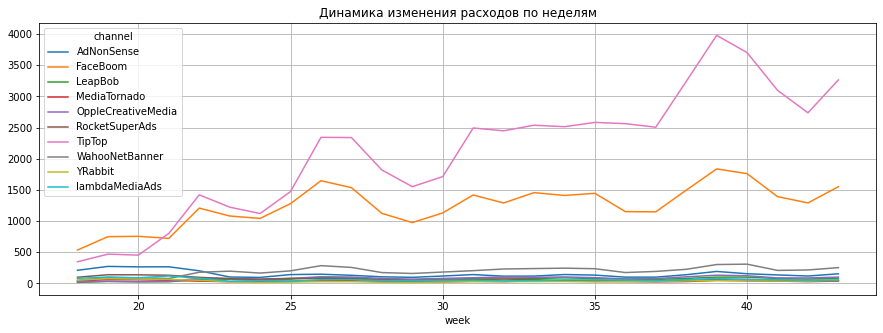

In [26]:
cost_1.pivot_table(
    index='week',  # даты первых посещений
    columns='channel',  # источники переходов
    values='costs', 
    aggfunc='sum'  # подсчёт 
).plot(figsize=(15, 5), grid=True)
plt.title('Динамика изменения расходов по неделям')
plt.show()

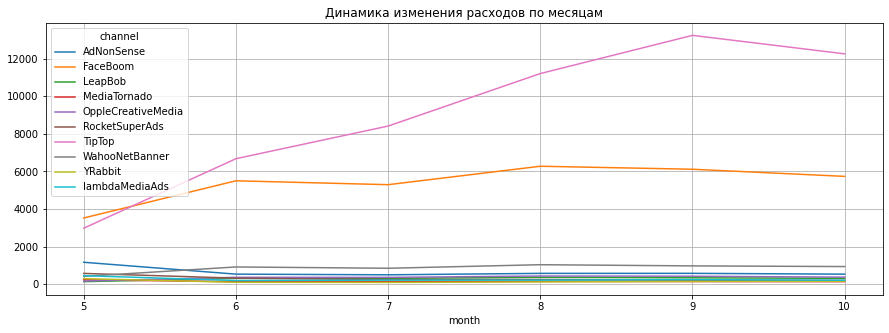

In [27]:
cost_1.pivot_table(
    index='month',  # даты первых посещений
    columns='channel',  # источники переходов
    values='costs',  
    aggfunc='sum'  # подсчёт 
).plot(figsize=(15, 5), grid=True)
plt.title('Динамика изменения расходов по месяцам')
plt.show()

Динамика расходов растут только на TipTop и FaceBoom у остальных эти расходы стабильны.

In [28]:
mean_a_cost = (profiles.groupby('channel')
               .agg({'acquisition_cost': 'mean'})
               .reset_index()
               .sort_values(by='acquisition_cost', ascending=False)
              )

display(mean_a_cost
        .style.set_table_styles([{'selector': 'caption', 'props': [('color', 'black'), ('font-size', '15px')]}])
        .set_caption('Средняя стоимость привлечение одного пользователя(CAC)').hide_index()
       ) 
cac = 105497/profiles_g['user_id'].count()
print('Cредний CAC на одного пользователя для всего проекта:', cac.round(1))

channel,acquisition_cost
TipTop,2.799003
FaceBoom,1.113286
AdNonSense,1.008054
lambdaMediaAds,0.724802
WahooNetBanner,0.602245
RocketSuperAds,0.412095
OppleCreativeMedia,0.250000
YRabbit,0.218975
MediaTornado,0.218717
LeapBob,0.210172


Cредний CAC на одного пользователя для всего проекта: 1.1


Самые большие траты на рекламные источники приходятся на FaceBoom и TipTop. Причем разрыв у TipTop средней стоимости привлечения одного пользователя в двое выше чем у FaceBoomи и самые большие общие расходы которые со временем растут. Однако количество привлечённых платных клиентов примерно в двое меньше, у FaceBoom 3557 клиентов, а у TipTop 1878 привлечённых платных пользователей.

## Оценка окупаемости рекламы

Используя графики LTV, ROI и CAC, проанализируем окупаемость рекламы. 

- Изучем окупаемость рекламы c помощью графиков LTV и ROI, а также графики динамики LTV, CAC и ROI.
- Проверим конверсию пользователей и динамику её изменения. То же самое сделайем с удержанием пользователей.
- Проанализируем окупаемость рекламы с разбивкой по устройствам. 
- Проанализируем окупаемость рекламы с разбивкой по странам.
- Проанализируем окупаемость рекламы с разбивкой по рекламным каналам. 

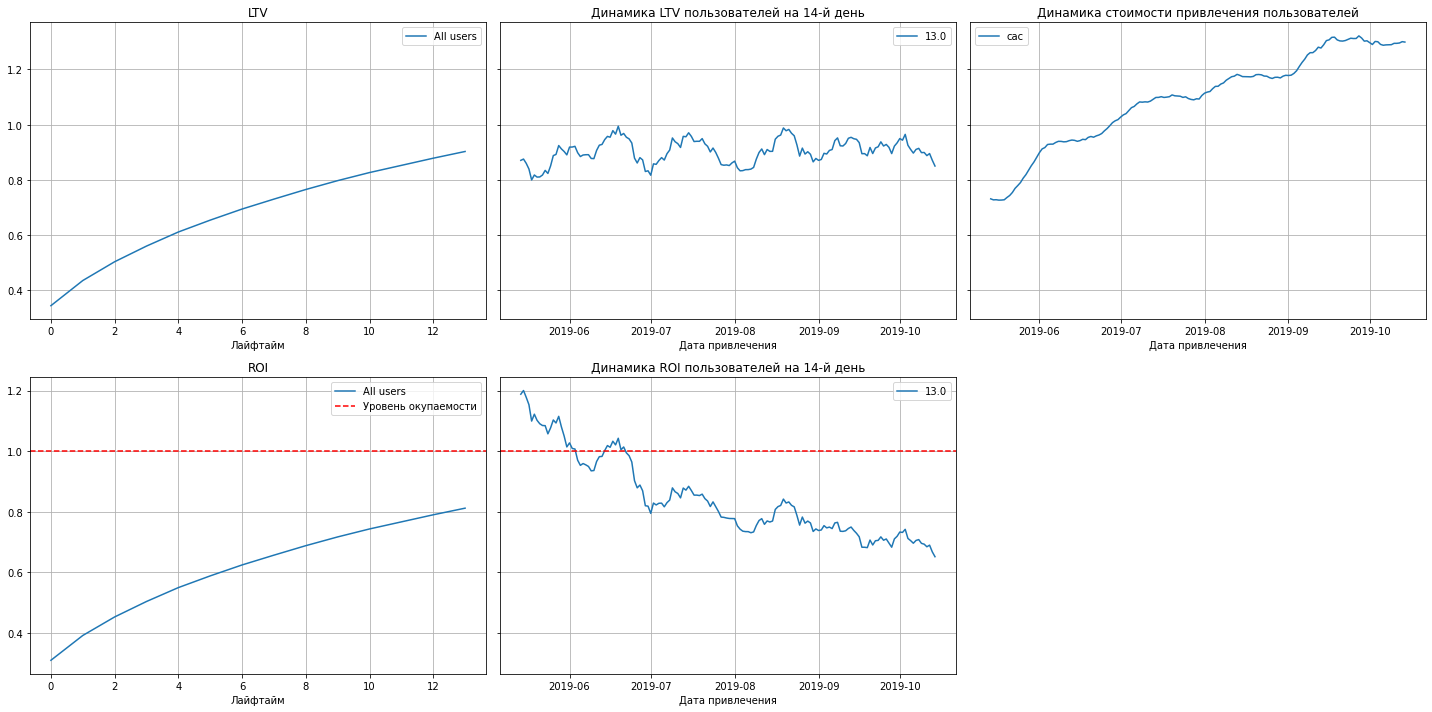

In [29]:
# считаем LTV и ROI
ltv_raw, ltv_grouped, ltv_history, roi_grouped, roi_history = get_ltv(
    profiles_g, orders, observation_date, horizon_days
)

# строим графики
plot_ltv_roi(ltv_grouped, ltv_history, roi_grouped, roi_history, horizon_days)

Из графиков можно понять следующие:
- LTV достаточно стабильно.
- Динамика САС со временем сильно возрастает, затраты на рекламные бюджеты очень велики.
- Реклама не окупается ROI в конце двух недель доходит примерна до 82%, а его динамика сильно проседает с течением времени. 

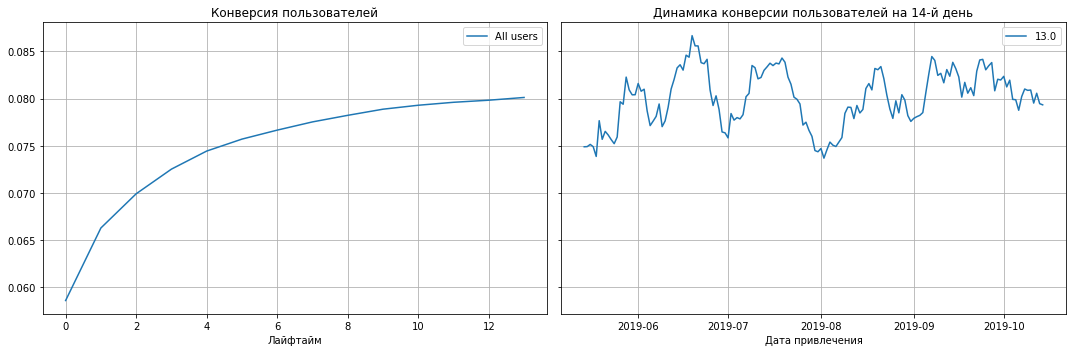

In [30]:
# смотрим конверсию

conversion_raw, conversion_grouped, conversion_history = get_conversion(
    profiles_g, orders, observation_date, horizon_days
)

plot_conversion(conversion_grouped, conversion_history, horizon_days) 


С конверсией пользователей все нормальна, она со временем растет.

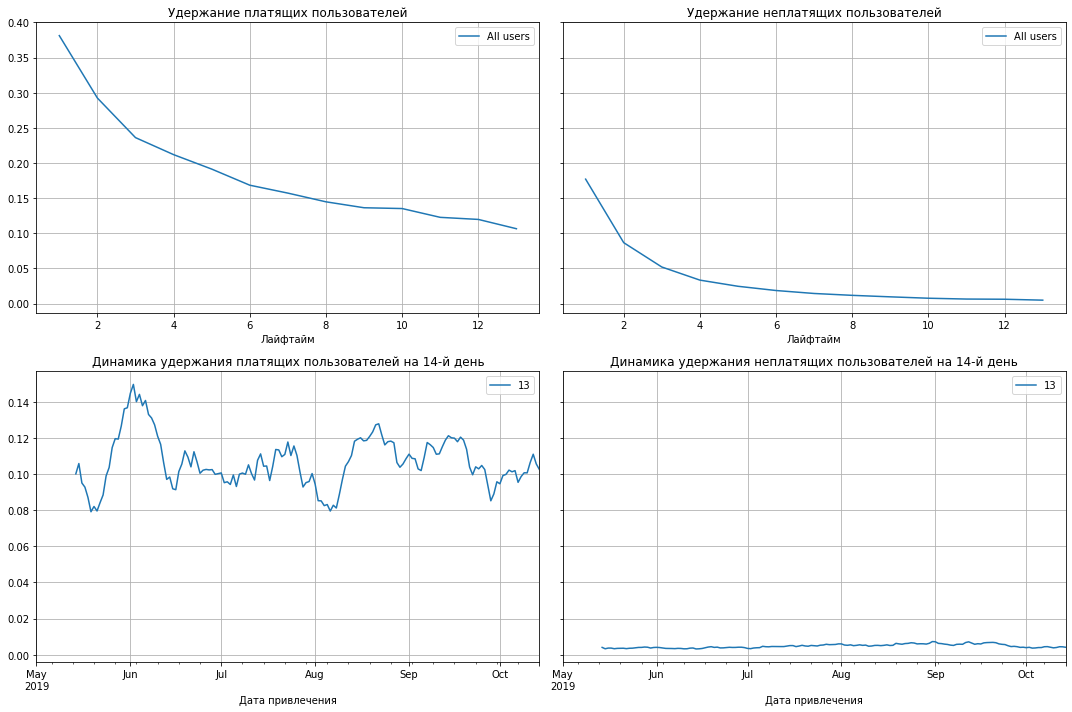

In [31]:
# смотрим удержание

retention_raw, retention_grouped, retention_history = get_retention(
    profiles_g, visits, observation_date, horizon_days
)

plot_retention(retention_grouped, retention_history, horizon_days) 

Удержание пользователей очень низкое, у платящих пользователей она начиная с 40% к концу второй недели она составляет не больше 13%.

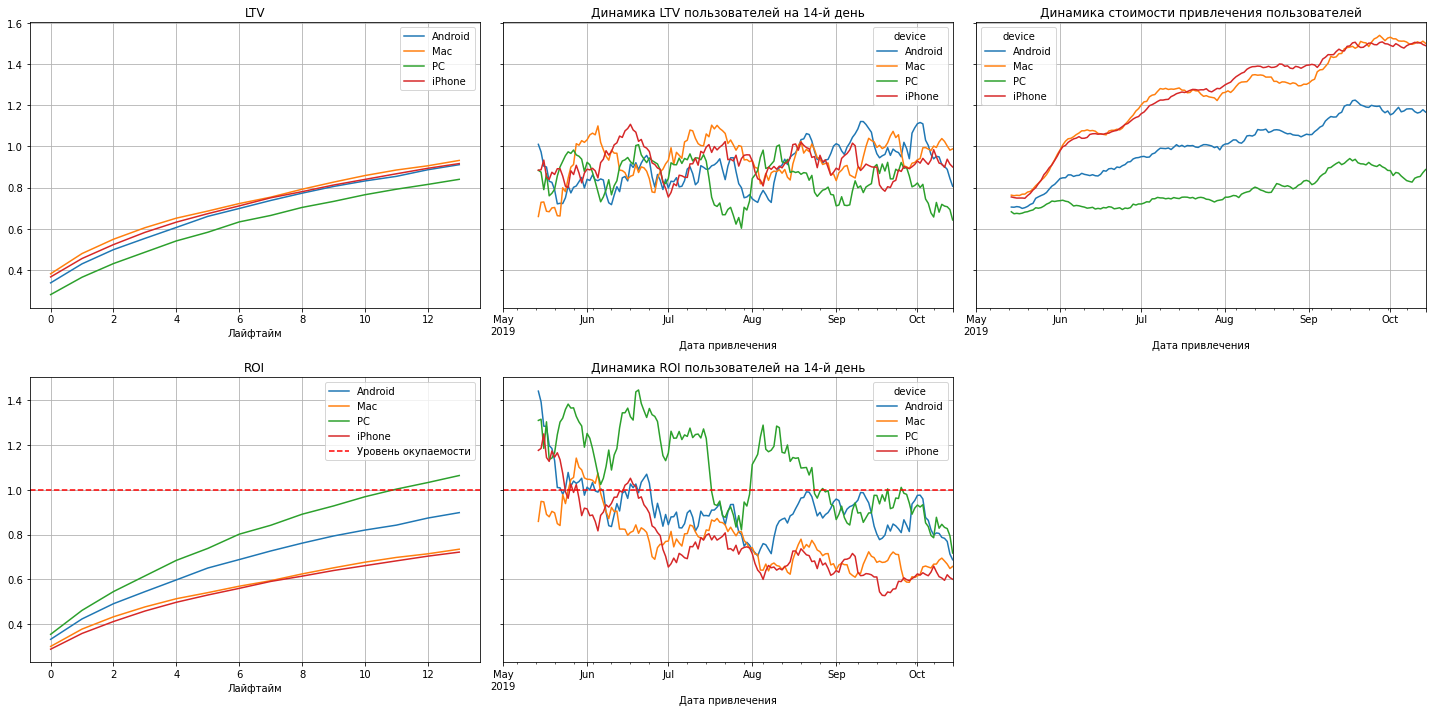

In [32]:
# смотрим окупаемость с разбивкой по устройствам

dimensions = ['device']

ltv_raw, ltv_grouped, ltv_history, roi_grouped, roi_history = get_ltv(
    profiles_g, orders, observation_date, horizon_days, dimensions=dimensions
)

plot_ltv_roi(
    ltv_grouped, ltv_history, roi_grouped, roi_history, horizon_days, window=14
) 

У Mac и iPhone больше всех растут затраты на привлечение пользователей, к октябрю они выросли выше 100%, а у Android и PC превышает половину. В течение двух недель окупаются только пользователи PC, затраты на рекламу у него наименьшие из всех и со временем не сильно растут, но в динамике ROI по месяцам все уходят в минус. 

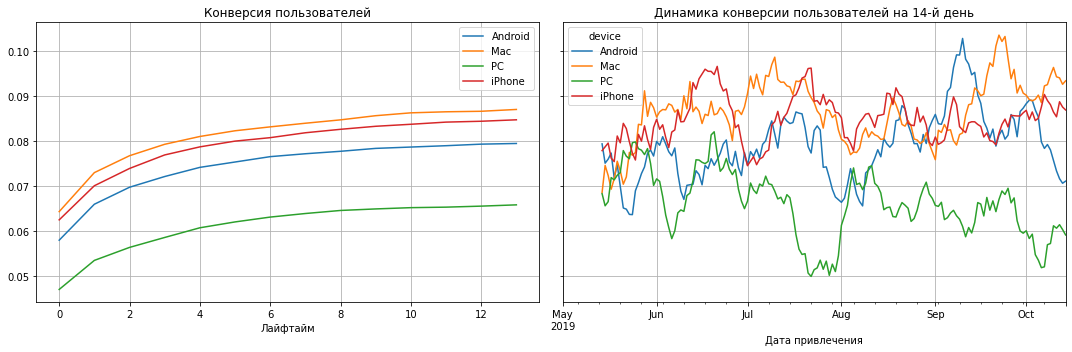

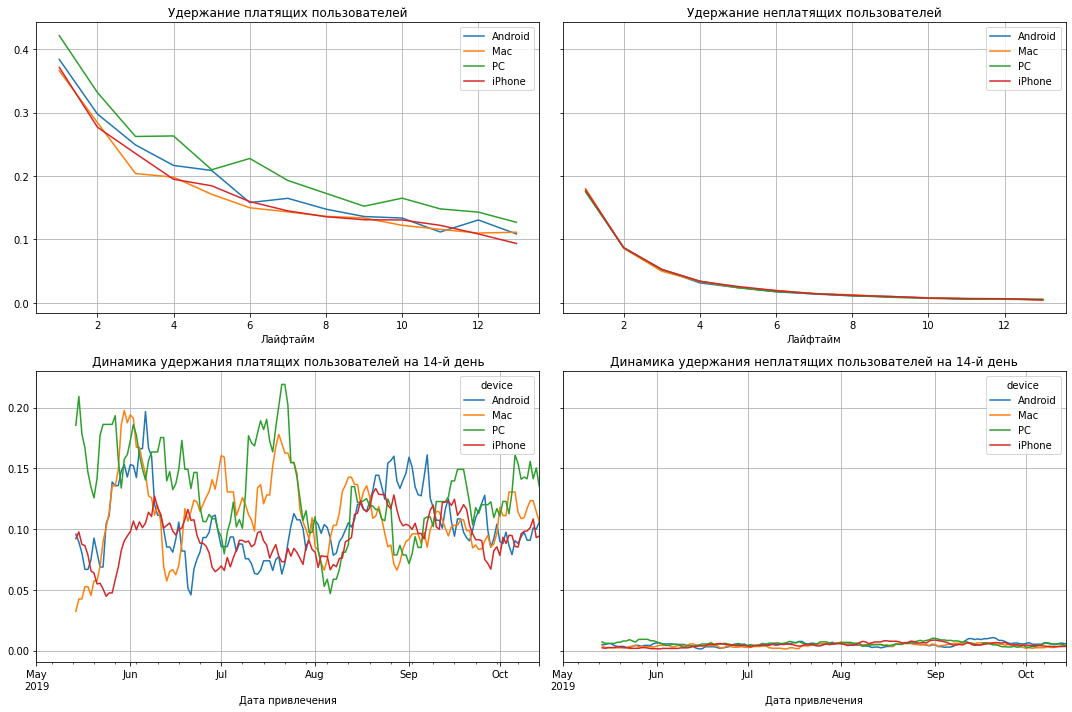

In [33]:
# смотрим конверсию  и удержание
conversion_raw, conversion_grouped, conversion_history = get_conversion(
    profiles_g, orders, observation_date, horizon_days, dimensions=dimensions
)

plot_conversion(conversion_grouped, conversion_history, horizon_days) 


retention_raw, retention_grouped, retention_history = get_retention(
    profiles_g, visits, observation_date, horizon_days, dimensions=dimensions
)

plot_retention(retention_grouped, retention_history, horizon_days) 

У РС конверсия ниже остальных, а удержание платящих пользователей не хуже и временами даже лучше.

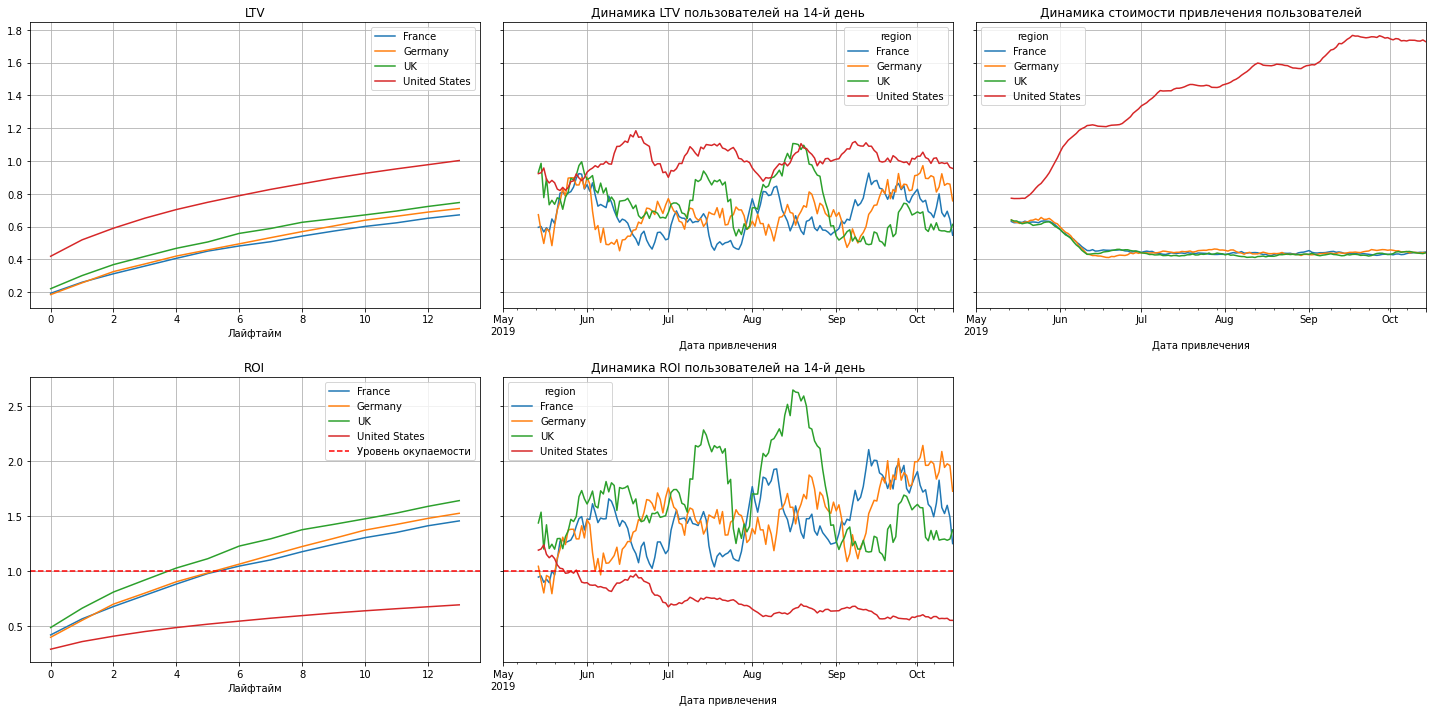

In [34]:
# смотрим окупаемость с разбивкой по странам

dimensions = ['region']

ltv_raw, ltv_grouped, ltv_history, roi_grouped, roi_history = get_ltv(
    profiles_g, orders, observation_date, horizon_days, dimensions=dimensions
)

plot_ltv_roi(
    ltv_grouped, ltv_history, roi_grouped, roi_history, horizon_days, window=14
) 

По графикам САС видно что США единственная страна которая увеличивает траты на привлечения клиентов в июне на 40% и продолжают их увеличивать, также эта единственная страна где инвестиции в рекламу не окупаются в течении 14 дней, а по динамики ROI видна что окупаемость клиентов в июне резка падает. 

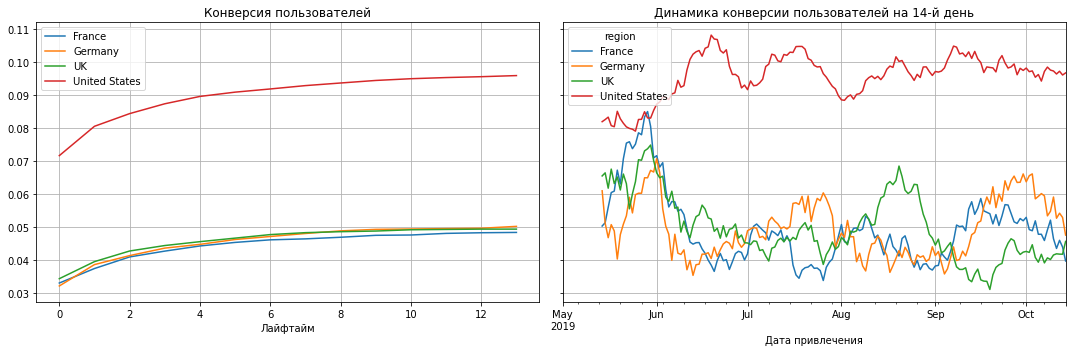

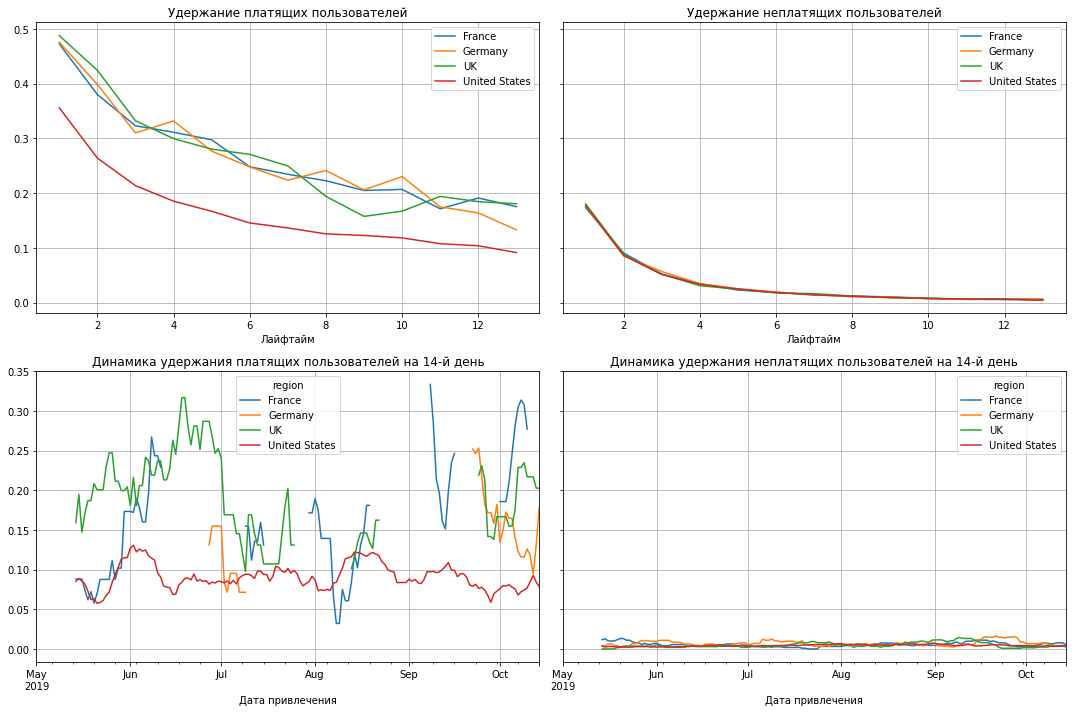

In [35]:
# смотрим конверсию  и удержание
conversion_raw, conversion_grouped, conversion_history = get_conversion(
    profiles_g, orders, observation_date, horizon_days, dimensions=dimensions
)

plot_conversion(conversion_grouped, conversion_history, horizon_days) 


retention_raw, retention_grouped, retention_history = get_retention(
    profiles_g, visits, observation_date, horizon_days, dimensions=dimensions
)

plot_retention(retention_grouped, retention_history, horizon_days) 

Конверсия пользователей у США самая высокая, а вот удержание платящих пользователей самое низкое. Деньги на рекламу в США  выделяются постоянно в отличии от других регионов.

In [36]:
mr = profiles_c.groupby(['region', 'channel']).agg({'user_id': 'count', 'acquisition_cost': 'sum'}).sort_values(by='acquisition_cost', ascending=False).reset_index()
mr = mr.query('region != "UK" and region != "France" and region != "Germany"')
mr['acquisition_cost'] = mr['acquisition_cost'].astype('int')
display(mr
        .style.set_table_styles([{'selector': 'caption', 'props': [('color', 'black'), ('font-size', '15px')]}])
        .set_caption('Распределения платных пользователей и затрат на рекламу по каналам в США ')
        .hide_index()
        )

region,channel,user_id,acquisition_cost
United States,TipTop,1878,5232
United States,FaceBoom,3557,3959
United States,RocketSuperAds,352,147
United States,YRabbit,165,34
United States,MediaTornado,156,33
United States,organic,794,0


Рекламу США в TipTop вкладывают больше денег чем в FaceBoom, но у FaceBoom платных пользователей больше.

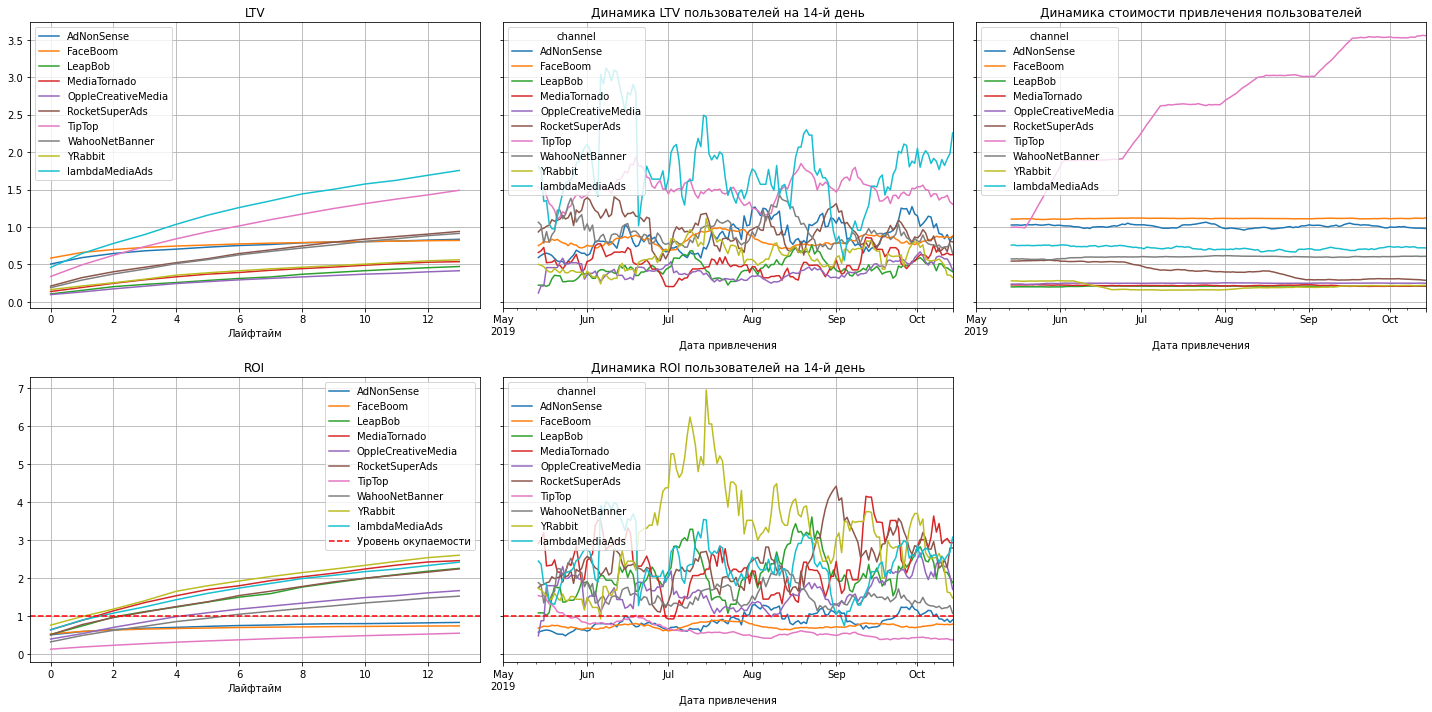

In [37]:
# смотрим окупаемость с разбивкой по источникам привлечения

dimensions = ['channel']

ltv_raw, ltv_grouped, ltv_history, roi_grouped, roi_history = get_ltv(
    profiles_g, orders, observation_date, horizon_days, dimensions=dimensions
)

plot_ltv_roi(
    ltv_grouped, ltv_history, roi_grouped, roi_history, horizon_days, window=14
) 

По LTV рекламных каналов видна что наибольшую сумму приносит клиент привлечённым с канала IambdaMediaAds и TipTop, однако на рекламу в  TipTop уходит горазда больше денег и расходы со временем сильна увеличиваются, также высокие расходы на рекламу в FaceBoom и AdNonSense хотя их LTV ниже чем у IambdaMediaAds. На графике ROI мы видим что FaceBoom, AdNonSense и TipTop не окупаются, тоже самое они показывают на графике динамики ROI. Топ три по окупаемости YRabbit, MediaTornado, IambdaMediaAds.

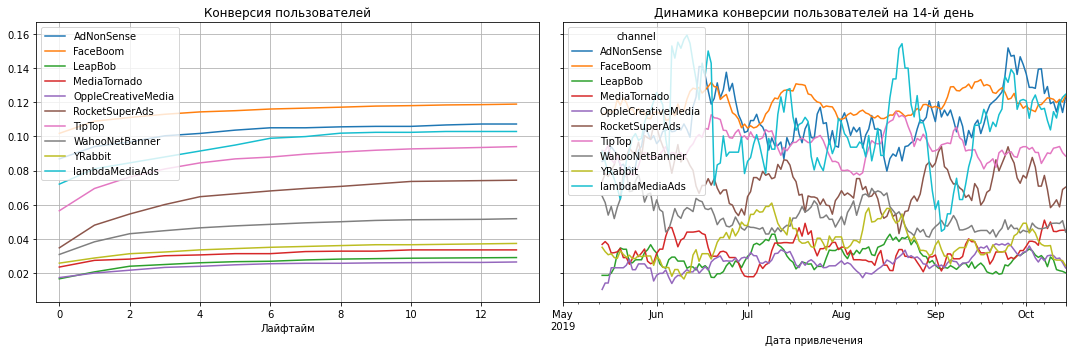

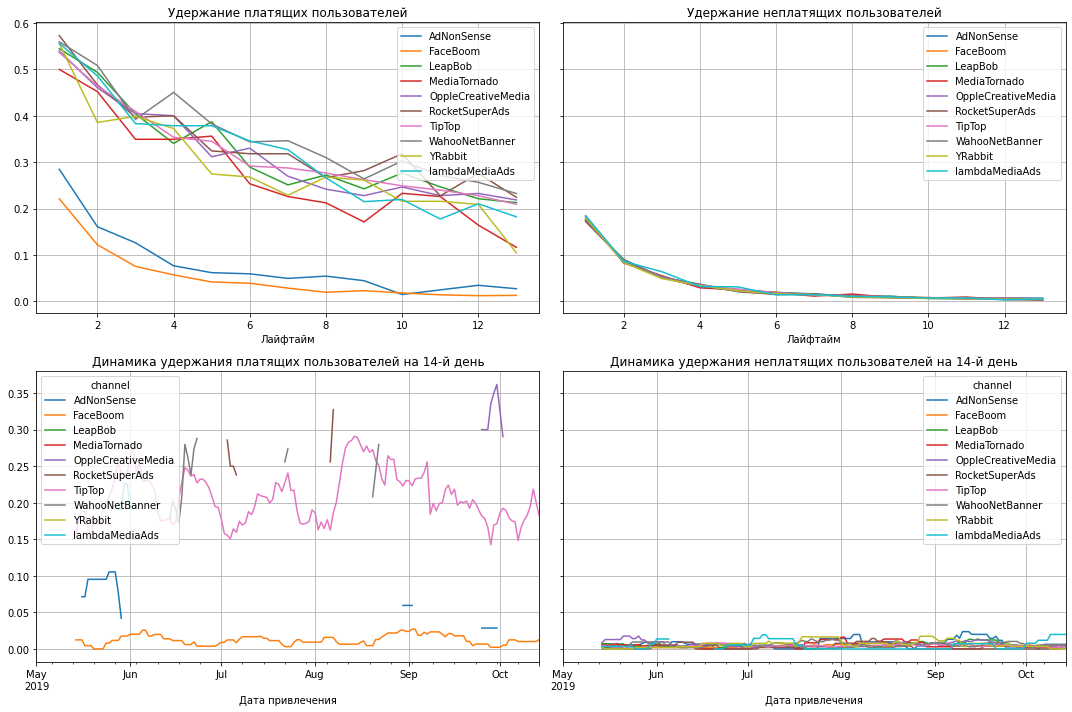

In [38]:
# смотрим конверсию  и удержание
conversion_raw, conversion_grouped, conversion_history = get_conversion(
    profiles_g, orders, observation_date, horizon_days, dimensions=dimensions
)

plot_conversion(conversion_grouped, conversion_history, horizon_days) 


retention_raw, retention_grouped, retention_history = get_retention(
    profiles_g, visits, observation_date, horizon_days, dimensions=dimensions
)

plot_retention(retention_grouped, retention_history, horizon_days) 

У FaceBoom и AdNonSense самая высокая конверсия пользователей, но очень низкое удержание. У TipTop хорошее удержание, но каналы в рекламу которых вкладывалось меньше средств находятся на том же уровне. Судя по всему в TipTop и FaceBoom рекламу финансируют постоянно, а в остальных каналах периодически на определенное время.

##  Общий вывод

Из полученных данных можно сделать выводы что: 

- в США с наибольшим количеством клиентов проблемы с распределением рекламного бюджета. На постоянной основе растет САС, но при этом ROI не окупается, а удержание клиентов очень низкое В динамики ROI и удержание платящих клиентов еще больше снижается по времени. Проблемы судя из данных в основном в этом регионе которые и влияют на общие показатели. 

- канал TipTop имеет хорошие удержание, но не лучше чем у других каналов хотя его рекламные инвестиции выше чем у других и САС постоянно растет, 14 дневной ROI не окупается в динамики ROI не подымается выше окупаемости с начала Июня. Нужна перестать повышать САС и устраивать рекламные компании в определённые периоды сезонов.

- канал FaceBoom, AdNonSense стабильный САС, но очень высокий видимо по этому LTV очень низкий, ROI не окупается и есть проблемы с удержанием клиентов. Стоит скорректировать стратегию по примеру IambdaMediaAds, FaceBoom также не стоит на постоянной основе, а выбирать наиболее благоприятные периоды для этого.

- у устройства iPhone, Mac и Android не окупаются инвестиции в рекламу чем выше САС тем ниже ROI, в двух недельный период окупается только PC, но и у него ROI в динамике начинает падать в конце Августа. Возможна стоит снизить САС до уровня Июня и держать примерно в этих рамках.

- Чтобы компании выйти в плюс нужна снизить затраты в США на рекламу в TipTop, FaceBoom, AdNonSense, сбалансировать политику инвестирования по примеру YRabbit, MediaTornado, IambdaMediaAds и перестать увеличивать вложения в TipTop, достаточно небольшого увеличения САС в 2-3% как это сделала Германия Великобритания и Франция где ROI стабильно окупается как на протяжение лайфтайма в 14 дней так и в динамики ROI.